In [9]:
from spectrumtools.spectrum import Spectrum, Source
from spectrumtools.generate_trapezoid_filter import generate_trapezoid_filter
from spectrumtools.analyze_waveform import plot_pulses, fit_tau, shape_waveform
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Lab0.h5
# Source: Co-60

# invert pulses false, 500 trigger delay, 170 trigger threshold
f_name = '../data/co60.h5'
f_data = h5py.File(f_name,'r')
co60_data = f_data['raw_data'][()]
co60_data = np.int64(co60_data) 


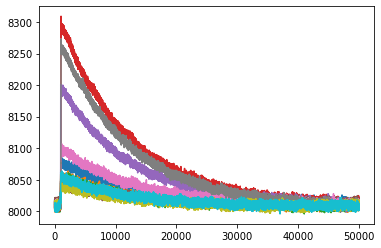

In [3]:
plot_pulses(co60_data, 10)

No handles with labels found to put in legend.


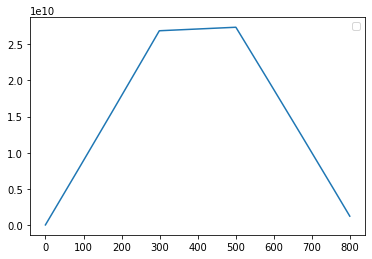

In [4]:
k = 300
l = 500
tau = 11000
trap_filter = generate_trapezoid_filter(tau, k, l)

plt.plot(trap_filter)

integral, filtered_signal = shape_waveform(co60_data[20], trap_filter, plot_filtered=True)

In [7]:
pulse_heights = np.zeros(len(co60_data))


for i in range(len(co60_data)):
    try:
        pulse_heights[i], signal = shape_waveform(co60_data[i], trap_filter)
    except:
        pass


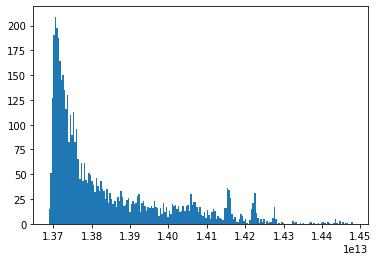

In [10]:
# Discard 0 valued pulses (waveform was anomalous)
spectrum_start = min(pulse_heights[pulse_heights > 0])
# Ignore high outliers above 99th percentile (mostly noise)
spectrum_end = np.quantile(pulse_heights, 0.99)

number_of_bins = 200

counts, bins = np.histogram(pulse_heights,
                            bins=number_of_bins, 
                            range=[spectrum_start, spectrum_end])

plt.hist(bins[:-1], bins, weights=counts)
#plt.yscale('log')
plt.show()